In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. 데이터 로드

In [2]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape
train.head(3)
test.head(3)
submission.head(3)

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45532 entries, 0 to 45531
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   QaA         45532 non-null  float64
 1   QaE         45532 non-null  int64  
 2   QbA         45532 non-null  float64
 3   QbE         45532 non-null  int64  
 4   QcA         45532 non-null  float64
 5   QcE         45532 non-null  int64  
 6   QdA         45532 non-null  float64
 7   QdE         45532 non-null  int64  
 8   QeA         45532 non-null  float64
 9   QeE         45532 non-null  int64  
 10  QfA         45532 non-null  float64
 11  QfE         45532 non-null  int64  
 12  QgA         45532 non-null  float64
 13  QgE         45532 non-null  int64  
 14  QhA         45532 non-null  float64
 15  QhE         45532 non-null  int64  
 16  QiA         45532 non-null  float64
 17  QiE         45532 non-null  int64  
 18  QjA         45532 non-null  float64
 19  QjE         45532 non-nul

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## 컬럼 분류

In [4]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


### Q_A

In [5]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


### Q_A 1/5 count

In [6]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q_A1'] = 0
train['Q_A3'] = 0
train['Q_A5'] = 0

test['Q_A1'] = 0
test['Q_A3'] = 0
test['Q_A5'] = 0

In [7]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q_A1'] = train.loc[i, 'Q_A1']+1
        elif v == 3:
            train.loc[i, 'Q_A3'] = train.loc[i, 'Q_A3']+1
        elif v == 5:
            train.loc[i, 'Q_A5'] = train.loc[i, 'Q_A5']+1            

Wall time: 2min 34s


In [8]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q_A1'] = test.loc[i, 'Q_A1']+1
        elif v == 3:
            test.loc[i, 'Q_A3'] = test.loc[i, 'Q_A3']+1            
        elif v == 5:
            test.loc[i, 'Q_A5'] = test.loc[i, 'Q_A5']+1                        

Wall time: 34.8 s


### Q_E

In [9]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
count,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04
mean,9.453570e+02,2.189589e+03,1484.294518,1.490672e+03,1.899292e+03,1.850650e+03,1.284608e+03,4.584272e+03,4.068434e+03,2.576363e+03,2.038986e+03,3.741018e+03,2.050287e+03,959.880502,1.435762e+03,1.633479e+03,1.154352e+03,2.470808e+03,1.164117e+03,2.240057e+03
std,1.307565e+04,3.351027e+04,8977.664318,1.092260e+04,1.670765e+04,7.608236e+04,9.756584e+03,5.020265e+05,1.141738e+05,5.411432e+04,3.069164e+04,3.663672e+05,7.530787e+04,5869.964127,1.084997e+04,2.600221e+04,2.250689e+04,1.482890e+05,7.433515e+03,6.730924e+04
min,2.500000e+01,2.500000e+01,25.000000,2.600000e+01,2.500000e+01,2.500000e+01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,25.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.500000e+01
25%,4.040000e+02,8.750000e+02,651.000000,6.790000e+02,8.340000e+02,5.040000e+02,5.490000e+02,1.077000e+03,1.259000e+03,9.020000e+02,8.590000e+02,8.060000e+02,6.500000e+02,428.000000,6.380000e+02,7.060000e+02,4.610000e+02,7.940000e+02,5.270000e+02,7.330000e+02
50%,5.570000e+02,1.218000e+03,899.000000,9.310000e+02,1.154000e+03,7.120000e+02,7.720000e+02,1.464000e+03,1.800000e+03,1.260000e+03,1.178000e+03,1.125000e+03,9.060000e+02,596.000000,8.830000e+02,9.700000e+02,6.520000e+02,1.117000e+03,7.470000e+02,1.020000e+03
75%,8.270000e+02,1.838000e+03,1335.000000,1.355000e+03,1.656000e+03,1.078000e+03,1.150000e+03,2.090000e+03,2.761000e+03,1.899000e+03,1.721000e+03,1.649000e+03,1.342000e+03,891.000000,1.300000e+03,1.409000e+03,9.820000e+02,1.664000e+03,1.124000e+03,1.526000e+03
max,2.413960e+06,5.580395e+06,871557.000000,1.552821e+06,1.919926e+06,1.176370e+07,1.068252e+06,1.070860e+08,1.703586e+07,9.910006e+06,4.824953e+06,7.754351e+07,1.410832e+07,606694.000000,1.309739e+06,4.650742e+06,4.277510e+06,3.159328e+07,1.286581e+06,1.155650e+07


,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889


### tp

In [10]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,3.017241,2.621189,1.768712,3.041246,1.335918,2.472217,2.031099,3.507226,2.277497,4.317996
std,2.007713,1.897081,1.685069,2.037278,1.452544,2.000658,1.785824,1.971456,1.848783,1.722793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000
75%,5.000000,4.000000,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,2,2,1,2,1,7,4,4,3
1,1,1,0,0,1,2,3,4,0,4
2,2,3,1,5,3,4,2,6,1,3


In [11]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [12]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if (v == 1 | v == 7):
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        if v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

Wall time: 15.9 s


In [13]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if (v == 1 | v == 7):
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        if v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

Wall time: 3.53 s


#### 극단값 중간값

In [14]:
train['Q_A15tp17'] = train['Q_A1'] + train['Q_A5'] + train['tp17']
train['Q_A3tp4'] = train['Q_A3'] + train['tp4']

In [15]:
test['Q_A15tp17'] = test['Q_A1'] + test['Q_A5'] + test['tp17']
test['Q_A3tp4'] = test['Q_A3'] + test['tp4']

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

## Target Encoding

### age_group

In [16]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [17]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [18]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [19]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [20]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [21]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

### education

In [22]:
train['education_int'] = train['education'].astype('int')
test['education_int'] = test['education'].astype('int')

train['education_n_rows'] = train['education_int'].map(train.groupby('education_int').size())
test['education_n_rows'] = test['education_int'].map(test.groupby('education_int').size())

education_mean = train.groupby('education_int')['voted'].mean()

train['education_mean'] = train['education_int'].map(education_mean)
test['education_mean'] = test['education_int'].map(education_mean)

train['education_mean_smoothing'] = train.apply(lambda x:smoothing(x['education_n_rows'], x['education_mean']), axis=1)
test['education_mean_smoothing'] = test.apply(lambda x:smoothing(x['education_n_rows'], x['education_mean']), axis=1)

train.drop(['education_int','education_mean', 'education_n_rows'], axis=1, inplace=True)
test.drop(['education_int','education_mean', 'education_n_rows'], axis=1, inplace=True)

## Outlier

In [23]:
train = train[train.familysize < 25]

## 인코딩

In [ ]:
#age_group, gender, race, religion
#train['age_group'] = train['age_group'].str.replace('s','').astype('int')
train['gender']= pd.factorize(train['gender'])[0]
train['race']=pd.factorize(train['race'])[0]
train['religion']=pd.factorize(train['religion'])[0]

#test['age_group'] = test['age_group'].str.replace('s','').astype('int')
test['gender']=pd.factorize(test['gender'])[0]
test['race']=pd.factorize(test['race'])[0]
test['religion']=pd.factorize(test['religion'])[0]

### One-hot

In [ ]:
train = pd.get_dummies(train, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
train

In [ ]:
test = pd.get_dummies(test, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
test

In [ ]:
train.shape, test.shape
train.columns.values
test.columns.values

In [ ]:
v = meta[meta.gbn=='Q_E'].index.values.tolist()
v.extend(['Q_A1', 'Q_A3',
       'Q_A5', 'tp17', 'tp4', 'Q_A15tp17', 'Q_A3tp4',
       'age_group_mean_smoothing'])
v

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True) 
train = pd.concat([train, interactions], axis=1)

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(test[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True) 
test = pd.concat([test, interactions], axis=1)

# 3. 모델 학습

In [24]:
from pycaret.classification import *

In [25]:
set_config('seed', 42)

In [26]:
import gc
gc.collect()

40

In [27]:
col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat

['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
 'race',
 'religion',
 'urban']

In [28]:
%%time
clf = setup(session_id=42, 
            data = train, target = 'voted'
          , categorical_features=col_cat
          , numeric_features = ['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 86)"
4,Missing Values,False
5,Numeric Features,29
6,Categorical Features,56
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 54.6 s


In [29]:
best_5 = compare_models(sort = 'AUC', n_select = 5
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6962,0.7671,0.6526,0.7582,0.7014,0.3958,0.4004,21.3335
1,Light Gradient Boosting Machine,0.6927,0.7642,0.6516,0.7531,0.6987,0.3885,0.3928,1.0352
2,CatBoost Classifier,0.6941,0.7641,0.6573,0.7521,0.7015,0.3907,0.3944,18.6765
3,Extra Trees Classifier,0.6926,0.7632,0.6402,0.7600,0.6949,0.3898,0.3957,2.9085
4,Linear Discriminant Analysis,0.6903,0.7626,0.6634,0.7428,0.7008,0.3820,0.3846,1.0414
5,Ada Boost Classifier,0.6910,0.7586,0.6608,0.7452,0.7005,0.3837,0.3867,5.2807
6,Extreme Gradient Boosting,0.6723,0.7428,0.6679,0.7142,0.6902,0.3432,0.3441,12.0182
7,Random Forest Classifier,0.6626,0.7183,0.6067,0.7306,0.6629,0.3310,0.3367,0.3196


In [30]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7026,0.7691,0.6607,0.7636,0.7084,0.4082,0.4126
1,0.7034,0.7747,0.6627,0.7638,0.7097,0.4097,0.4140
2,0.6940,0.7719,0.6535,0.7540,0.7002,0.3910,0.3952
3,0.6909,0.7649,0.6531,0.7493,0.6979,0.3844,0.3883
4,0.6864,0.7684,0.6466,0.7460,0.6927,0.3758,0.3798
Mean,0.6955,0.7698,0.6553,0.7553,0.7018,0.3938,0.3980
SD,0.0066,0.0033,0.0058,0.0073,0.0064,0.0132,0.0134


In [31]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6947,0.7661,0.653,0.7555,0.7005,0.3924,0.3968


In [34]:
final_model = finalize_model(blended)

In [35]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [36]:
submission['voted'] = predictions['Score']

# 5. 제출

In [37]:
submission.to_csv('output/20201003-2-X-education_mean_smoothing.csv')

In [32]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7073,0.7774,0.6557,0.7744,0.7102,0.4186,0.4246
1,0.6844,0.7501,0.6459,0.7434,0.6912,0.3718,0.3757
2,0.6979,0.7623,0.6582,0.7575,0.7044,0.3986,0.4027
3,0.7109,0.7810,0.6705,0.7710,0.7172,0.4244,0.4288
4,0.7055,0.7789,0.6648,0.7658,0.7117,0.4138,0.4181
5,0.6809,0.7633,0.6328,0.7452,0.6844,0.3660,0.3710
6,0.6996,0.7670,0.6516,0.7644,0.7035,0.4029,0.4082
7,0.6924,0.7600,0.6571,0.7493,0.7002,0.3871,0.3906
8,0.7058,0.7758,0.6538,0.7730,0.7084,0.4158,0.4217
9,0.6776,0.7557,0.6358,0.7381,0.6831,0.3586,0.3628


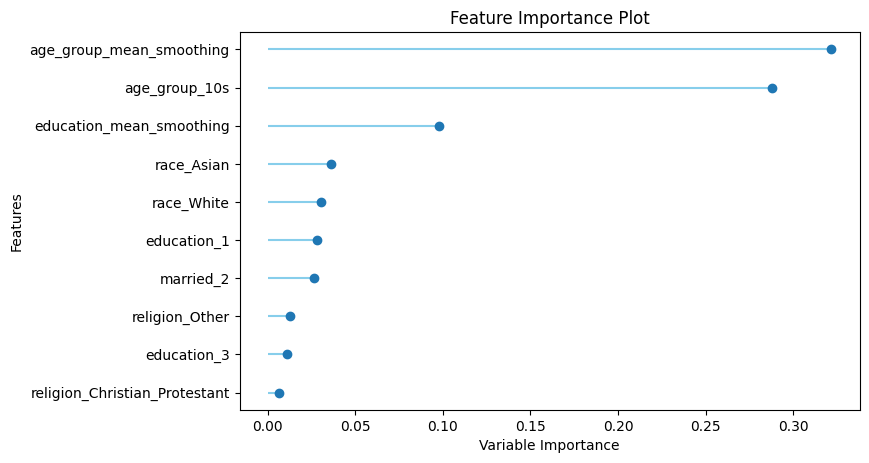

In [33]:
plot_model(estimator = gbc, plot = 'feature')